# Multimodal RAG over Market Research Surveys

<a href="https://colab.research.google.com/github/run-llama/llamacloud-demo/blob/main/examples/multimodal/mm_market_survey_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows you how to get started by building a multi-modal RAG pipeline over a [SAS Generative AI Global Research Report](https://www.sas.com/content/dam/SAS/documents/marketing-whitepapers-ebooks/ebooks/en/generative-ai-global-research-report-113914.pdf).

## Build Multimodal LlamaCloud Index

We first build a multimodal LlamaCloud Index (a RAG pipeline) over the research report.

To create the index, follow the instructions:
1. You can download the [file](https://www.sas.com/content/dam/SAS/documents/marketing-whitepapers-ebooks/ebooks/en/generative-ai-global-research-report-113914.pdf).
2. In the "Create Index" page, make sure to toggle the **Multi-Modal Indexing** option. This will also render page screenshots for every document and store/index them along with the text for retrieval.
3. If you wish you can also customize the LlamaParse settings for text extraction (including using a multi-modal model for text extraction too).

After the index is created, you're welcome to check out the Playground. Make sure to toggle "Multi-modal Retrieval". Given a question, you will get answers over image and text data, and both the text and image sources will show up.

![](mm_market_survey_ai_images/sample_slide.png)

![](mm_market_survey_ai_images/playground.png)

## Build Multi-modal RAG Pipeline Through Code

Now that the index is setup, we're ready to integrate it into code.

In [ ]:
!pip install llama-index-indices-llama-cloud

In [1]:
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex

index = LlamaCloudIndex(
  name="<index_name>", 
  project_name="<project_name>",
  organization_id="...",
  api_key="llx-..."
)

## Multimodal Retrieval

Let's first define a multimodal retriever - we'll see that we're able to return both text and image nodes.

In [2]:
from PIL import Image 
from llama_index.core.schema import ImageNode
from IPython.display import display

def _render_image_nodes(nodes):
    # go through nodes, render the ones that are image nodes
    image_nodes = [n for n in nodes if isinstance(n.node, ImageNode)]
    for image_node in image_nodes:
        image = Image.open(image_node.node.resolve_image())
        display(image)

In [38]:
retriever = index.as_retriever(retrieve_image_nodes=True, rerank_top_n=5)

In [39]:
nodes = retriever.retrieve(
    "What are the differences between different regions in genAI adoption (experimentation to full implementation)"
)

The first few nodes are all TextNodes. We can easily filter for image nodes and render them.

In [ ]:
print(nodes[0].get_content())

_render_image_nodes(nodes)

## Try out an Example Query! 

Now we can try out an example query against the multimodal index. Here we build a custom multi-modal query engine, since our default `RetrieverQueryEngine` only operates over text nodes.

In [41]:
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode, TextNode
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from typing import Optional


gpt_4o = OpenAIMultiModal(model="gpt-4o", max_new_tokens=4096)

QA_PROMPT_TMPL = """\
Below we give parsed text and images as context.

Use both the parsed text and images to answer the question. 

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)

class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: OpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        img_nodes = [n for n in nodes if isinstance(n.node, ImageNode)]
        text_nodes = [n for n in nodes if isinstance(n.node, TextNode)]
        
        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
        )
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[n.node for n in img_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": text_nodes, "image_nodes": img_nodes},
        )

        return response

In [42]:
query_engine = MultimodalQueryEngine(retriever=retriever, multi_modal_llm=gpt_4o)

In [9]:
response = query_engine.query("What are the differences between different regions in genAI adoption (experimentation to full implementation)")

In [10]:
print(str(response))

The differences between different regions in GenAI adoption, from experimentation to full implementation, are as follows:

1. **Current Usage Rates**:
   - **APAC**: 63%
   - **North America**: 60%
   - **Northern Europe**: 55%
   - **South West LATAM**: 47%
   - **Eastern Europe**: 47%

2. **Full Implementation**:
   - **North America**: 20%
   - **APAC**: 10%
   - **LATAM**: 8%
   - **South West Europe**: 7%
   - **Eastern Europe**: 7%

3. **Using but Not Fully Implemented**:
   - **APAC**: 53%
   - **Northern Europe**: 47%
   - **North America**: 40%
   - **South West Europe**: 39%
   - **LATAM**: 37%

4. **Regional Leaders**:
   - **China, the UK, the US, Australia, and Germany** are ahead in GenAI adoption.
   - **US** organizations are particularly advanced in full implementation.

5. **Sector Leaders**:
   - **Telco companies** are more advanced in GenAI adoption, followed by **retail, insurance, banking, and life sciences**.
   - **Manufacturing, the public sector, and healthca

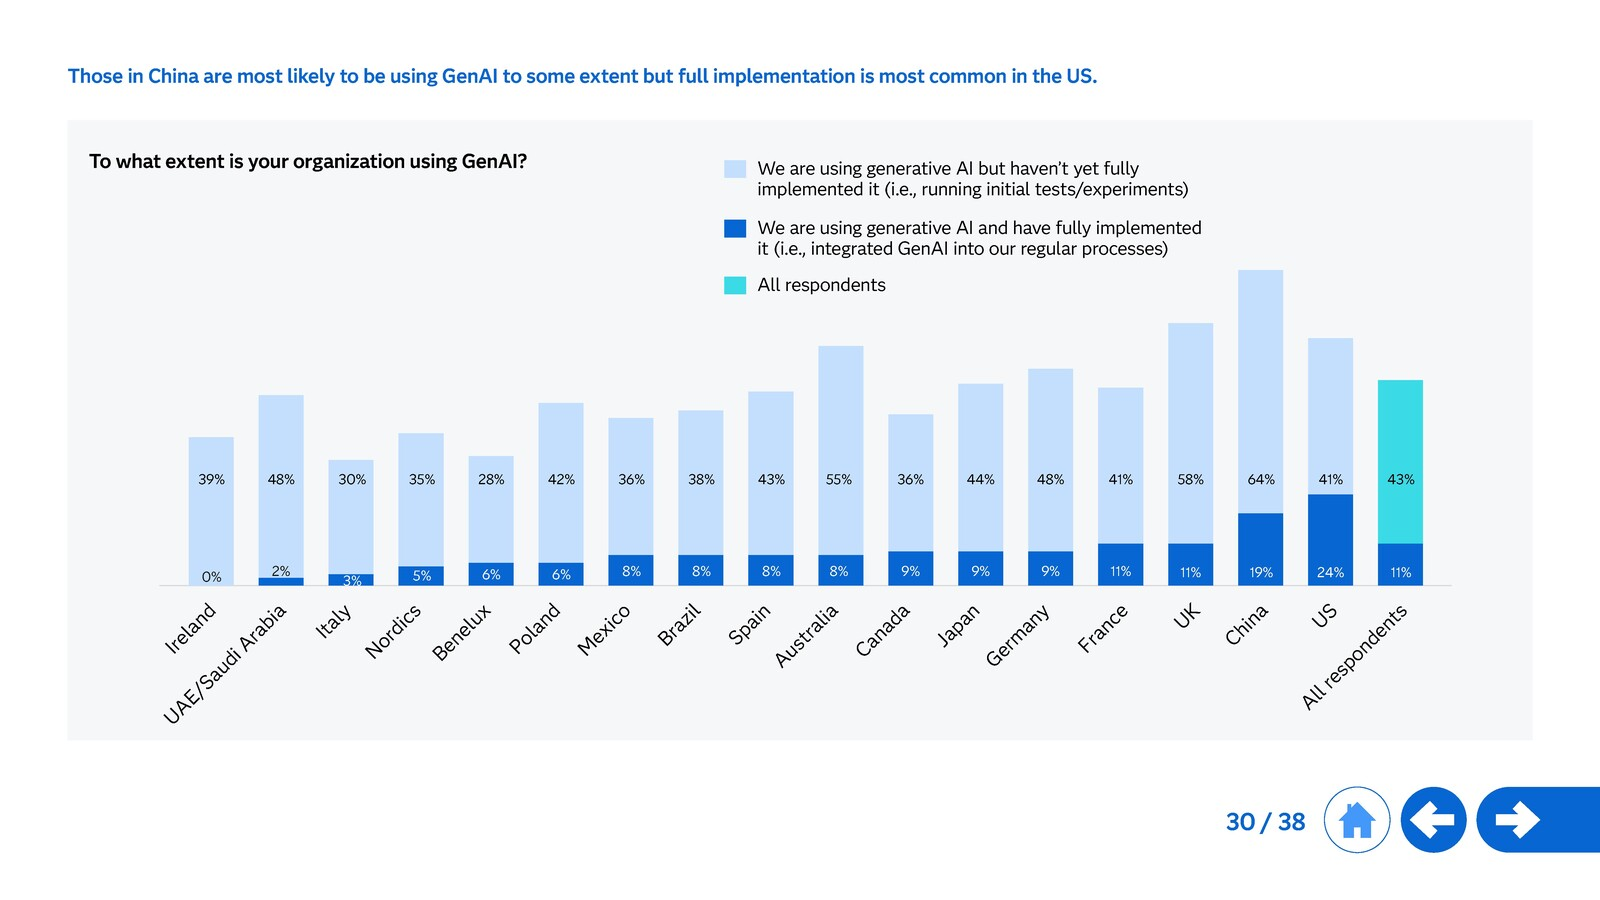

In [16]:
# NOTE: currently in the last retrieved node - YMMV based on the embedding model used
_render_image_nodes(response.metadata["image_nodes"][-1:])

In [52]:
response = query_engine.query("How are organizations thinking about scaling genAI efforts (buy vs. build)?")

In [53]:
print(str(response))

Organizations are considering both buying and building approaches for scaling GenAI efforts. According to the provided text and images, the breakdown is as follows:

- **Buying (Enlisting third parties)**:
  - 27% are enlisting a third party for GenAI integration.
  - 19% are using an enterprise-grade orchestration platform across third-party and open source.
  - 21% are integrating GenAI as a built-in feature of enterprise applications.
  - 46% are planning to enlist third-party support to ensure they make the most of GenAI’s potential.

- **Building (In-house development)**:
  - 13% are exploring use cases.
  - 13% are focusing on in-house development on open source.
  - 6% are rethinking their enterprise data strategy.

From the data, it is evident that a significant portion of organizations are leaning towards enlisting third-party support and using orchestration platforms, indicating a preference for buying solutions. However, there is also a notable percentage focusing on in-hous

# Scaling GenAI within Business Processes

Many are enlisting third parties to support GenAI integration, including through orchestration platforms.

# How do you envision scaling GenAI within your business processes?

|Approach|Percentage|
|---|---|
|Enlisting a third party for GenAI integration|27%|
|As a built-in feature of enterprise applications|21%|
|Through an enterprise-grade orchestration platform across third-party and open source|19%|
|Exploration of use cases|13%|
|In-house development on open source|13%|
|Rethink our enterprise data strategy|6%|

32 / 38


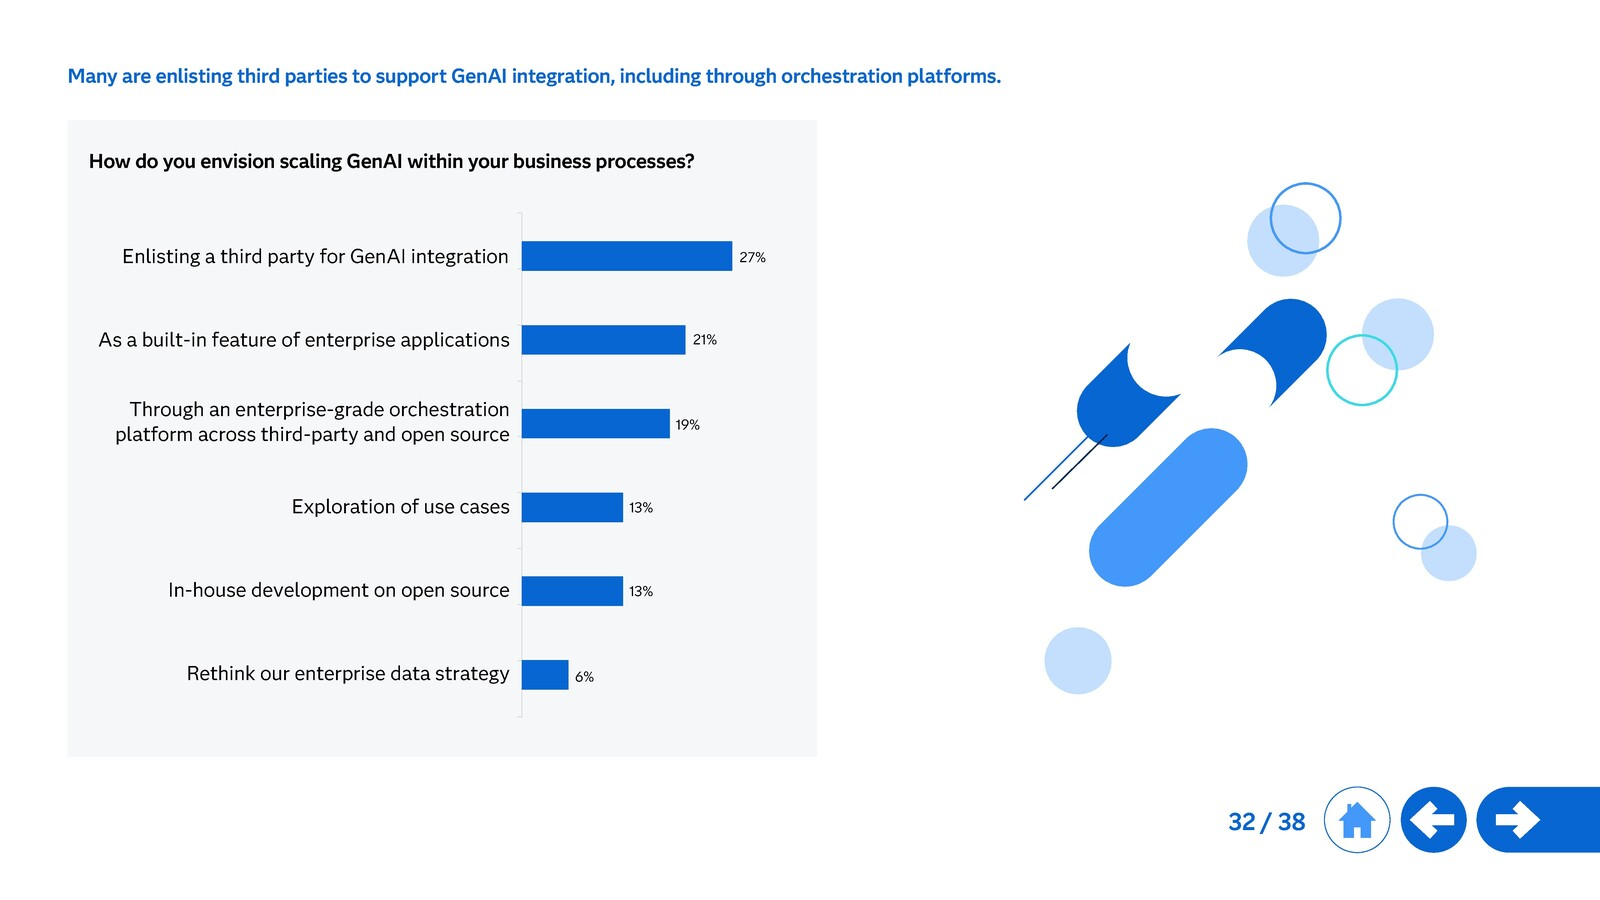

In [57]:
# NOTE: currently in the 1st node - YMMV based on the embedding model used
print(response.source_nodes[0].get_content())
_render_image_nodes(response.metadata["image_nodes"][0:1])